### Note
기존 모델과 다른 점
- 기존 2가지 유형의 모델은 모두 Transformers 기반의 Large Scale 모델이다.
- 파라미터 개수가 너무 많아서 Inference 및 학습이 오래 걸린다.
- 모델의 크기를 줄여 서비스에 용이하도록 한다.
- 기존은 파인튜닝 기반으로 성능을 높였다.

목적
- 이전보다 크기가 작은 모델을 만드는 것이 주목적
- MoE를 기반으로 빠른 Inference가 가능하도록 설계

### 0. 라이브러리

In [38]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mon Jun 17 04:42:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              40W / 300W |    789MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os

# cuda 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random
import math
import dataclasses

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchsummary import summary

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from peft import get_peft_model, LoraConfig, TaskType

In [5]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fixSEED(seed=42)

In [6]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print(path)

/home/leesanghyuk2000/Python_Programs


In [7]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 데이터 불러오기

In [8]:
# Load data from a pickle file, and create labels
def callData(path: str):
    with open(path, "rb") as file:
        data = pickle.load(file)

    zero = data[data['label']==0]
    non_zero = data[data['label']==1]

    print(f'레이블 0 개수 : {len(zero)}')
    print(f'레이블 1 개수 : {len(non_zero)}')

    return data


In [9]:
# load data
aihub_data = callData("AiHub_Sampled(2000).pkl")

레이블 0 개수 : 990
레이블 1 개수 : 992


In [10]:
# 유튜브 데이터 불러오기
youtube_data = callData('youtubeData(8331)_with_label.pkl')

레이블 0 개수 : 5208
레이블 1 개수 : 3123


In [11]:
# concat two data
text1 = aihub_data['newsContent'] # 제목 미포함
text2 = youtube_data['content'] # 제목 미포함

label1 = aihub_data['label']
label2 = youtube_data['label']

data = pd.DataFrame({
    'text': pd.concat([text1, text2], ignore_index=True),
    'label': pd.concat([label1, label2], ignore_index=True)
})

In [13]:
# 레이블 개수 확인
data['label'].value_counts()

label
0    6198
1    4115
Name: count, dtype: int64

### 2. Train/Valid/Test

In [14]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify = data['label'])
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED, stratify = train_val_data['label'])

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [15]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 6187개 
검증용 데이터 개수 : 2063개 
평가용 데이터 개수 : 2063개


### 3. Dataset 및 Dataloader 정의

In [16]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [17]:
# Dataset 정의
class MoEDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text'] # 자동생성자막과 기사 본문만
        label = self.data.iloc[index]['label']
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long) # 정수형

### 4. 모델 정의

```keras```로 작성된 Text classification with Switch Transformer 코드를 참고
- https://keras.io/examples/nlp/text_classification_with_switch_transformer/

In [18]:
# Hyperparameters
embed_dim = 128
num_heads = 2
ff_dim = 32
num_experts = 8
learning_rate = 1e-4
dropout_rate = 0.1

# Dataset parameters
batch_size = 32  # Reduced batch size to fit within GPU memory limits
num_tokens_per_example = 200
num_tokens_per_batch = batch_size * num_tokens_per_example
num_labels = 2
max_length = 64
num_epochs = 10
wait_for_es = 5

#### 4-1. Implement token & position embedding layer

It consists of two separate embedding layers, one for tokens, one for token index (positions).

In [19]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, max_len, embed_dim):
        """
        :param vocab_size: total vocab size
        :param max_len: max length of seqeunce
        :param embed_dim: embedding size of token embedding
        """
        super().__init__()
        self.token_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=1)
        self.pos_emb = nn.Embedding(num_embeddings=max_len, embedding_dim=embed_dim)

    def forward(self, sequence):

        max_seq_len = sequence.shape[-1]

        positions = torch.tensor(range(max_seq_len)).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        positions = self.pos_emb(positions)
        emb_out = self.token_emb(sequence) + positions 
        return emb_out

#### 4-2. Implement the feedforward network

This is used as the Mixture of Experts in the Switch Transformer.

In [20]:
# 이 함수에 의해 expert 개수만큼 FFN 생성하게 됨
def create_feedforward_network(embed_dim, ff_dim):
    return nn.Sequential(
        nn.Linear(embed_dim, ff_dim), 
        nn.ReLU(),
        nn.Linear(ff_dim, ff_dim)
    ).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

#### 4-3. Implement the load-balanced loss

This is an auxiliary loss to encourage a balanced load across experts.

In [21]:
def load_balanced_loss(router_probs, expert_mask):
    # router_probs [tokens_per_batch, num_experts] is the probability assigned for
    # each expert per token. expert_mask [tokens_per_batch, num_experts] contains
    # the expert with the highest router probability in one−hot format.
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_experts = torch.tensor(expert_mask.shape[-1]).to(device)
    # Get the fraction of tokens routed to each expert.
    # density is a vector of length num experts that sums to 1.
    density = torch.mean(expert_mask.type(torch.FloatTensor), dim=0).to(device)
    # Get fraction of probability mass assigned to each expert from the router
    # across all tokens. density_proxy is a vector of length num experts that sums to 1.
    density_proxy = torch.mean(router_probs, dim=0).to(device)
    # Want both vectors to have uniform allocation (1/num experts) across all
    # num_expert elements. The two vectors will be pushed towards uniform allocation
    # when the dot product is minimized.
    loss = torch.mean(density_proxy * density) * torch.tensor(num_experts ** 2).type(torch.FloatTensor)
    return loss

#### 4-4. Implement the router as a layer

In [22]:
class Router(nn.Module):
    def __init__(self, embed_dim, num_experts, expert_capacity):
        super().__init__()
        self.num_experts = num_experts
        self.route = nn.Linear(embed_dim, num_experts)
        self.expert_capacity = expert_capacity
        

    def forward(self, x, training=False):
        # inputs shape: [tokens_per_batch, embed_dim]
        # router_logits shape: [tokens_per_batch, num_experts]
        router_logits = self.route(x)

        if training:
            # Add noise for exploration across experts. [0.9, 1.1]
            router_logits += torch.FloatTensor(router_logits.shape).uniform_(0.9, 1.1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Probabilities for each token of what expert it should be sent to.
        router_probs = F.softmax(router_logits, dim=-1)
        # Get the top−1 expert for each token. expert_gate is the top−1 probability
        # from the router for each token. expert_index is what expert each token
        # is going to be routed to.
        
        # 확률값, 확률값이 최대인 index
        expert_gate, expert_index = torch.topk(router_probs, k=1) # 10000, 1

        # expert_mask shape: [tokens_per_batch, num_experts]
        # 토큰 별로 행당하는 expert index를 one hot으로 표현
        expert_mask = F.one_hot(expert_index, num_classes=self.num_experts) # 10000, 1, 10

        # Compute load balancing loss.
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        # print(f'expert balalancing loss ---> {aux_loss}')
        
        # Experts have a fixed capacity, ensure we do not exceed it. Construct
        # the batch indices, to each expert, with position in expert make sure that
        # not more that expert capacity examples can be routed to each expert.
        
        position_in_expert = (torch.cumsum(expert_mask, dim=0) * expert_mask).type(torch.int32) # 10000, 1, 10
        
        # Keep only tokens that fit within expert capacity.
        # 10000, 1, 10
        # true/false
        expert_mask *=torch.less(
                position_in_expert.type(torch.int32), self.expert_capacity
            )
        
        # tf.one_hot -> keras에서는 index 넘어가는 것 알아서 0으로 만들어 줌
        # torch.one_hot은 그렇지 안아서 직접 masking 해줌
        
        # Opinion : 0으로 되면 값 전달이 안되는데? -> 위의 balance loss 학습으로 균일하게 expert를 부여할 수 있도록 학습되는 과정에서 해결
        position_in_expert *= expert_mask

        # 10000, 1
        # one-hot encoding에서 capacity로 인해 masking 이 됐다면 0, masking 안 됐다면 1로 차원 축소
        expert_mask_flat = torch.sum(expert_mask, dim=-1)
        
        # Mask out the experts that have overflowed the expert capacity.
        # expert에 대한 확률값도 masking
        expert_gate *= expert_mask_flat
        
        # Combine expert outputs and scaling with router probability.
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        
        # expert_gate   :  TensorShape([10000, 1])
        # expert_mask_flat   :   TensorShape([10000, 10])
        # torch.squeeze(F.one_hot(expert_index.long(), num_classes=self.num_experts)  :  TensorShape([10000, 10, 1000])

        # TensorShape([10000, 10, 1]) *  TensorShape([10000, 10, 1000])
        # TensorShape([10000, 10, 1000])
        
        # 결론 [tokens_per_batch, num_experts, expert_capacity] shape에 해당하는 expert probability가 들어간다!!
        # 어떤 토큰이 어떤 expert의 capacity 순서에서 확률값을 갖는지
        combined_tensor = torch.unsqueeze(
            expert_gate
            * expert_mask_flat
            * torch.squeeze(F.one_hot(expert_index.long(), num_classes=self.num_experts), 1),
            -1,
        ) * torch.squeeze(F.one_hot(position_in_expert.long(), num_classes=self.expert_capacity), 1)
       
        # Create binary dispatch_tensor [tokens_per_batch, num_experts, expert_capacity]
        # that is 1 if the token gets routed to the corresponding expert.
        
        # keras는 설명과 다르게 구현
        # 논문에 의하면 boolean이 맞음
        dispatch_tensor = (combined_tensor > 0).type(torch.float32)

        return dispatch_tensor, combined_tensor, aux_loss


#### 4-5. Implement a Switch layer

In [23]:
class Switch(nn.Module):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, ff_dim, capacity_factor=1):
        super().__init__()
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = nn.ModuleList([create_feedforward_network(self.embed_dim, ff_dim) for _ in range(num_experts)])
        self.num_tokens_per_batch = num_tokens_per_batch
        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(embed_dim, self.num_experts, self.expert_capacity)

    def forward(self, x):
        batch_size = x.shape[0]
        num_tokens_per_example = x.shape[1]
        #print(f'Input shape: {x.shape}')
        
        # Flatten the input to [num_tokens_per_batch, embed_dim]
        inputs = torch.reshape(x, [-1, self.embed_dim])
        #print(f'Reshaped input: {inputs.shape}')
        
        dispatch_tensor, combine_tensor, aux_loss = self.router(inputs, training=True)
        
        expert_inputs = torch.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        #print(f'Expert inputs after einsum: {expert_inputs.shape}')
        
        expert_inputs = torch.reshape(expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim])
        #print(f'Expert inputs reshaped: {expert_inputs.shape}')
        
        expert_output_list = [self.experts[idx](expert_input) for idx, expert_input in enumerate(expert_inputs)]
        expert_outputs = torch.stack(expert_output_list, dim=1)
        #print(f'Expert outputs stacked: {expert_outputs.shape}')
        
        expert_outputs_combined = torch.einsum("abc,xba->xc", expert_outputs, combine_tensor)
        #print(f'Expert outputs combined: {expert_outputs_combined.shape}')
        
        outputs = torch.reshape(expert_outputs_combined, [batch_size, num_tokens_per_example, self.embed_dim])
        #print(f'Final output: {outputs.shape}')
        
        return outputs, aux_loss

#### 4-6. Implement a Transformer block layer

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.0, d_k = None):
        super().__init__()
        
        self.d_model = d_model
        if d_k:
            self.d_k = d_k
        else:
            self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, heads * d_k)
        self.v_linear = nn.Linear(d_model, heads * d_k)
        self.k_linear = nn.Linear(d_model, heads * d_k)
        self.out = nn.Linear(heads * d_k, d_model)

    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        
        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)

        scores = F.softmax(scores, dim=-1)

        if dropout is not None:
            scores = dropout(scores)

        output = torch.matmul(scores, v)
        
        return output
    
    def forward(self, q, k, v, mask=None):
                
        bs = q.size(0)
        len_q = q.size(1)
        
        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

       # calculate attention using function we will define next
        scores = self.attention(q, k, v, self.d_k, mask)                       
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, len_q, -1) 
        output = self.out(concat)
    
        return output


class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [25]:
# Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, switch_ffn, dropout = 0.1):
        super().__init__()
        self.attn = MultiHeadAttention(heads=num_heads, d_model=embed_dim, d_k=embed_dim)
        # The ffn can be either a standard feedforward network or a switch
        # layer with a Mixture of Experts.
        self.ffn = switch_ffn
        self.norm_1 = Norm(embed_dim)
        self.norm_2 = Norm(embed_dim)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # x : torch.Size([50, 200, 32])
        # self attention + add&norm
        attn_output = self.attn(x, x, x, mask)
        attn_output = self.dropout_1(attn_output)
        norm_output = self.norm_1(x + attn_output)
        
        # ffn + add&norm
        ffn_output, aux_loss = self.ffn(norm_output)
        ffn_output = self.dropout_2(ffn_output)
        out = self.norm_2(norm_output + ffn_output)
        return out, aux_loss

#### 4-7. Implement the classifier

The ```TransformerBlock``` layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feedforward network on top of it to classify text.

In [26]:
class SwitchTransformer(nn.Module):
    def __init__(self, device, vocab_size, num_experts, num_tokens_per_example, num_tokens_per_batch, embed_dim, num_heads, ff_dim, dropout):
        super(SwitchTransformer, self).__init__()
        self.switch = Switch(num_experts, embed_dim, num_tokens_per_batch, ff_dim)
        self.embedding_layer = TokenAndPositionEmbedding(vocab_size, num_tokens_per_example, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, switch_ffn=self.switch)
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, 2)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, inputs):
        x = self.embedding_layer(inputs)
        x, aux_loss = self.transformer_block(x)
        x = torch.squeeze(torch.mean(x, dim=1))
        x = self.dropout_1(x)
        x = self.dropout_2(F.relu(self.linear1(x)))
        outputs = self.linear2(x)
        return outputs, aux_loss

### 5. 학습용 Trainer 정의

In [27]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 100)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 100)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'▶️ Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./saved_models/Youtube/YouTube(mixed)_MoE_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'▶️ Model Saved to {save_path}')
                except Exception as e:
                    print(f'▶️ Model Not Saved: {e}')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'▶️▶️▶️ Early Stopping at Epoch {epoch+1} ◀️◀️◀️')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, _, y = batch
            input_ids, y = input_ids.to(self.device), y.to(self.device)

            outputs, lb_loss = self.model(input_ids)
            loss = self.criterion(outputs, y) + lb_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, _, y = batch
                input_ids, y = input_ids.to(self.device), y.to(self.device)

                outputs, lb_loss = self.model(input_ids)
                loss = self.criterion(outputs, y) + lb_loss

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)

### 6. 학습 진행

In [28]:
model_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [29]:
# 데이터셋 정의
train_dataset = MoEDataset(train_data, tokenizer, max_length)
valid_dataset = MoEDataset(valid_data, tokenizer, max_length)
test_dataset = MoEDataset(test_data, tokenizer, max_length)

In [30]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0,  5284,  2069,  ...,  1972,  2203,     2],
         [    0,  8241,  3211,  ...,  2073,  3629,     2],
         [    0,  3666,  4601,  ...,  2496,  2259,     2],
         ...,
         [    0,  8633, 22267,  ...,  6294,  3912,     2],
         [    0,  5891,  2205,  ...,  3669,  2073,     2],
         [    0,  3738,  7339,  ...,  2079,  4264,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
         1, 1, 0, 1, 0, 1, 0, 1])]

In [31]:
model = SwitchTransformer(device=device, 
                          vocab_size=tokenizer.vocab_size, 
                          num_experts=10,
                          num_tokens_per_example=200, 
                          num_tokens_per_batch=batch_size * num_tokens_per_example, 
                          embed_dim=32, 
                          num_heads=2, 
                          ff_dim=32, 
                          dropout=0.25).to(device)

In [32]:
# 훈련 가능한 파라미터 수 확인
print_trainable_parameters(model)

Trainable Params: 1061516 
All params: 1061516
--------------------------------------------------
Trainable(%): 100.0


In [33]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [34]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [35]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

----------------------------------------------------------------------------------------------------
Epoch 1/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s]


[Train] 	 Loss: 1.6941 	 Acc: 0.5543 	 Precision: 0.3057 	 Recall: 0.2893 	 F1: 0.2472
[Valid] 	 Loss: 1.6768 	 Acc: 0.6005 	 Precision: 0.0000 	 Recall: 0.0000 	 F1: 0.0000
▶️ Epoch 1 complete in 0m 43s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.
----------------------------------------------------------------------------------------------------
Epoch 2/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  6.08it/s]


[Train] 	 Loss: 1.6721 	 Acc: 0.6009 	 Precision: 0.0000 	 Recall: 0.0000 	 F1: 0.0000
[Valid] 	 Loss: 1.6665 	 Acc: 0.6021 	 Precision: 0.0000 	 Recall: 0.0000 	 F1: 0.0000
▶️ Epoch 2 complete in 1m 25s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.
----------------------------------------------------------------------------------------------------
Epoch 3/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  6.03it/s]


[Train] 	 Loss: 1.6635 	 Acc: 0.6007 	 Precision: 0.0000 	 Recall: 0.0000 	 F1: 0.0000
[Valid] 	 Loss: 1.6590 	 Acc: 0.6016 	 Precision: 0.0000 	 Recall: 0.0000 	 F1: 0.0000
▶️ Epoch 3 complete in 2m 7s
----------------------------------------------------------------------------------------------------
Epoch 4/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  6.00it/s]


[Train] 	 Loss: 1.6515 	 Acc: 0.6014 	 Precision: 0.0284 	 Recall: 0.0024 	 F1: 0.0043
[Valid] 	 Loss: 1.6420 	 Acc: 0.6026 	 Precision: 0.0308 	 Recall: 0.0031 	 F1: 0.0056
▶️ Epoch 4 complete in 2m 50s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.
----------------------------------------------------------------------------------------------------
Epoch 5/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:11<00:00,  5.90it/s]


[Train] 	 Loss: 1.6215 	 Acc: 0.6305 	 Precision: 0.4844 	 Recall: 0.1015 	 F1: 0.1588
[Valid] 	 Loss: 1.6047 	 Acc: 0.6726 	 Precision: 0.7476 	 Recall: 0.2963 	 F1: 0.4075
▶️ Epoch 5 complete in 3m 33s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.
----------------------------------------------------------------------------------------------------
Epoch 6/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  6.21it/s]


[Train] 	 Loss: 1.5707 	 Acc: 0.7005 	 Precision: 0.7075 	 Recall: 0.4390 	 F1: 0.5246
[Valid] 	 Loss: 1.5547 	 Acc: 0.7202 	 Precision: 0.6837 	 Recall: 0.5755 	 F1: 0.6142
▶️ Epoch 6 complete in 4m 14s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.
----------------------------------------------------------------------------------------------------
Epoch 7/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  6.15it/s]


[Train] 	 Loss: 1.5187 	 Acc: 0.7457 	 Precision: 0.7015 	 Recall: 0.6373 	 F1: 0.6563
[Valid] 	 Loss: 1.5285 	 Acc: 0.7434 	 Precision: 0.6919 	 Recall: 0.6551 	 F1: 0.6645
▶️ Epoch 7 complete in 4m 56s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.
----------------------------------------------------------------------------------------------------
Epoch 8/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  6.16it/s]


[Train] 	 Loss: 1.4908 	 Acc: 0.7655 	 Precision: 0.7119 	 Recall: 0.6889 	 F1: 0.6906
[Valid] 	 Loss: 1.5257 	 Acc: 0.7337 	 Precision: 0.6463 	 Recall: 0.7747 	 F1: 0.6939
▶️ Epoch 8 complete in 5m 38s
----------------------------------------------------------------------------------------------------
Epoch 9/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s]


[Train] 	 Loss: 1.4693 	 Acc: 0.7740 	 Precision: 0.7157 	 Recall: 0.7290 	 F1: 0.7103
[Valid] 	 Loss: 1.5079 	 Acc: 0.7580 	 Precision: 0.7050 	 Recall: 0.6774 	 F1: 0.6818
▶️ Epoch 9 complete in 6m 21s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.
----------------------------------------------------------------------------------------------------
Epoch 10/10
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s]

[Train] 	 Loss: 1.4528 	 Acc: 0.7876 	 Precision: 0.7329 	 Recall: 0.7365 	 F1: 0.7257
[Valid] 	 Loss: 1.4992 	 Acc: 0.7581 	 Precision: 0.6965 	 Recall: 0.7025 	 F1: 0.6918
▶️ Epoch 10 complete in 7m 5s
▶️ Model Not Saved: Parent directory ./saved_models/Youtube does not exist.


In [36]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    fig = plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

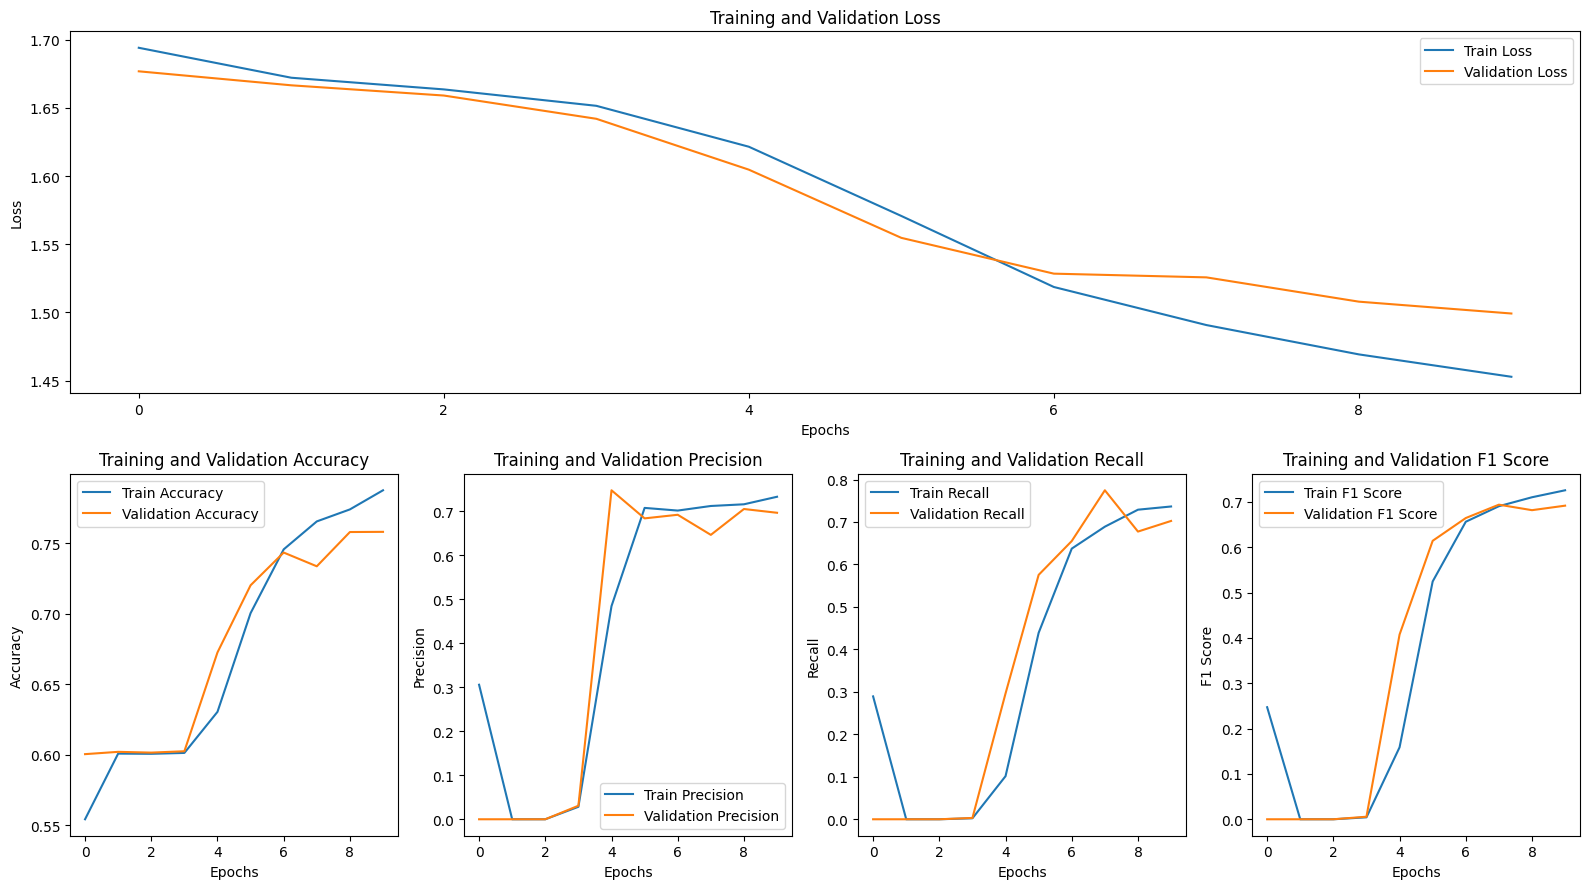

In [37]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)